In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-0.4.0-SNAPSHOT-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '../../','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
for col in dframe.columns:
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
    node_list.add(nodi)

In [7]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(dframe.index),dframe.columns.size)

In [8]:
for col in range(0,dframe.columns.size):
    for row in dframe.index:
        value = javabridge.JClassWrapper("java.lang.Double")(dframe.iloc[row,col])
        dataBox.set(row,col,value)

In [9]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [10]:
alpha = 0.05
depth = -1
verbose = True
numBootstrap = 5
ensembleMethod = 'Preserved'

In [11]:
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.independence.FisherZ')()
algorithm = javabridge.JClassWrapper('edu.cmu.tetrad.algcomparison.algorithm.oracle.pag.Rfci')(indTest)

In [12]:
parameters = javabridge.JClassWrapper('edu.cmu.tetrad.util.Parameters')()
parameters.set('depth', depth)
parameters.set('alpha', alpha)
parameters.set('verbose', verbose)

In [13]:
rfci = javabridge.JClassWrapper('edu.pitt.dbmi.algo.bootstrap.GeneralBootstrapTest')(boxData, algorithm, numBootstrap)

In [14]:
edgeEnsemble = javabridge.get_static_field('edu/pitt/dbmi/algo/bootstrap/BootstrapEdgeEnsemble',
                                               ensembleMethod,
                                               'Ledu/pitt/dbmi/algo/bootstrap/BootstrapEdgeEnsemble;')
rfci.setEdgeEnsemble(edgeEnsemble)
rfci.setParameters(parameters)

In [15]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('TangibilityCondition', 'Impact') # forbidden directed edges
prior.setRequired('Sympathy','TangibilityCondition') # required directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'TangibilityCondition')
prior.addToTier(0, 'Imaginability')
prior.addToTier(1, 'Sympathy')
prior.addToTier(1, 'AmountDonated')
prior.addToTier(2, 'Impact')
rfci.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

0* Imaginability TangibilityCondition 
1 AmountDonated Sympathy 
2 Impact 

forbiddirect

TangibilityCondition ==> Impact 
requiredirect

Sympathy ==> TangibilityCondition 

In [16]:
tetradGraph = rfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraph: Graph Nodes:
AmountDonated,Imaginability,Impact,Sympathy,TangibilityCondition

Graph Edges:
1. AmountDonated o-> Impact [AmountDonated o-> Impact]:0.6000;[no edge]:0.4000;
2. Imaginability o-> AmountDonated [AmountDonated <-o Imaginability]:0.4000;[no edge]:0.6000;
3. Imaginability o-> Impact [Imaginability o-> Impact]:1.0000;
4. Imaginability o-> Sympathy [Imaginability o-> Sympathy]:0.8000;[no edge]:0.2000;
5. Sympathy --> AmountDonated [AmountDonated --> Sympathy]:0.2000;[AmountDonated o-o Sympathy]:0.2000;[AmountDonated <-- Sympathy]:0.6000;
6. Sympathy o-> Impact [Impact <-o Sympathy]:1.0000;
7. Sympathy --> TangibilityCondition [Sympathy --> TangibilityCondition]:1.0000;

In [17]:
tetradGraph.toString()

'Graph Nodes:\nAmountDonated,Imaginability,Impact,Sympathy,TangibilityCondition\n\nGraph Edges:\n1. AmountDonated o-> Impact [AmountDonated o-> Impact]:0.6000;[no edge]:0.4000;\n2. Imaginability o-> AmountDonated [AmountDonated <-o Imaginability]:0.4000;[no edge]:0.6000;\n3. Imaginability o-> Impact [Imaginability o-> Impact]:1.0000;\n4. Imaginability o-> Sympathy [Imaginability o-> Sympathy]:0.8000;[no edge]:0.2000;\n5. Sympathy --> AmountDonated [AmountDonated --> Sympathy]:0.2000;[AmountDonated o-o Sympathy]:0.2000;[AmountDonated <-- Sympathy]:0.6000;\n6. Sympathy o-> Impact [Impact <-o Sympathy]:1.0000;\n7. Sympathy --> TangibilityCondition [Sympathy --> TangibilityCondition]:1.0000;\n'

In [18]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [AmountDonated, Imaginability, Impact, Sympathy, TangibilityCondition]

In [19]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [Imaginability o-> AmountDonated [AmountDonated <-o Imaginability]:0.4000;[no edge]:0.6000;, Sympathy --> AmountDonated [AmountDonated --> Sympathy]:0.2000;[AmountDonated o-o Sympathy]:0.2000;[AmountDonated <-- Sympathy]:0.6000;, Sympathy o-> Impact [Impact <-o Sympathy]:1.0000;, Sympathy --> TangibilityCondition [Sympathy --> TangibilityCondition]:1.0000;, AmountDonated o-> Impact [AmountDonated o-> Impact]:0.6000;[no edge]:0.4000;, Imaginability o-> Sympathy [Imaginability o-> Sympathy]:0.8000;[no edge]:0.2000;, Imaginability o-> Impact [Imaginability o-> Impact]:1.0000;]

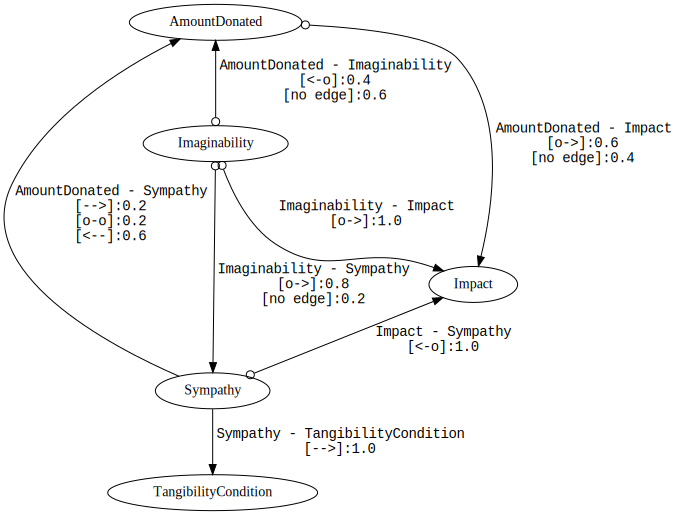

In [20]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [21]:
javabridge.detach()
javabridge.kill_vm()